In [1]:
!pip install yfinance
# Importing the libraries
import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

#Get the stock quote in a dataframe
import yfinance as yf
df = yf.download('AAPL', start = '2012-01-01', end='2019-12-12')


[*********************100%%**********************]  1 of 1 completed


In [2]:
#Show the data
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466091,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533086,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672229,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804702,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784392,394024400
...,...,...,...,...,...,...
2019-12-05,65.947502,66.472504,65.682503,66.394997,64.769356,74424400
2019-12-06,66.870003,67.750000,66.824997,67.677498,66.020454,106075600
2019-12-09,67.500000,67.699997,66.227501,66.730003,65.096146,128042400


In [3]:
df.shape

(1999, 6)

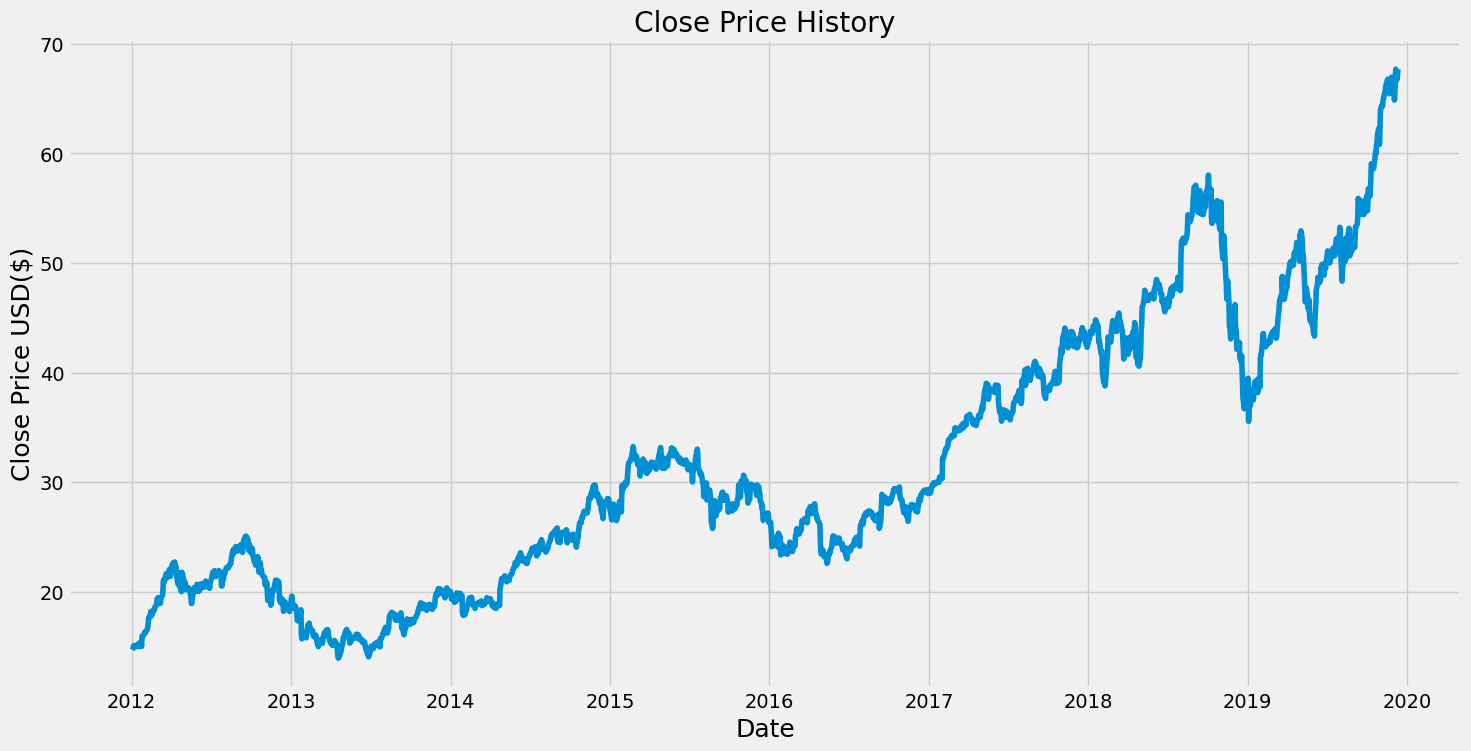

In [4]:
#Visualize the closing price history

plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()


In [5]:
#Create a new dataframe with only the 'Close' column
data=df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset=data.values

#Compute the number of rows to train the model on
training_data_len= math.ceil(len(dataset) * .8)

#scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

#Create scaled training data set
train_data=scaled_data[0:training_data_len,:]

#split the data into x_train and y_train data sets

x_train =[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  # if i<=60: #checking trained data
  #   print(x_train)
  #   print(y_train)
  #   print()

#convert train data to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)
#Reshape into the shape accepted by the LSTM
x_train.shape


(1540, 60)

In [6]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1540, 60, 1)

In [7]:
# build LSTM network model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#copile the model
model.compile(optimizer='adam',loss='mean_squared_error')

#train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1540/1540 [==============================] - 47s 28ms/step - loss: 7.9955e-04


In [8]:
#create the testing data set
test_data=scaled_data[training_data_len - 60:,:]

#create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
#Get all of the rows from index 1603 to the rest and all of the
#columns (in this case it's only column 'Close'),
#so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

#convert the test data to a numpy array
x_test=np.array(x_test)

#reshape
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#get the models predicted price values
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions) #undo scaling

#Get the root mean squared error(RMSE)
rmse=np.sqrt( np.mean((predictions - y_test)**2))
rmse


13/13 [==============================] - 1s 38ms/step


1.4776578439862806

<ipython-input-9-4466a73b8c35>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


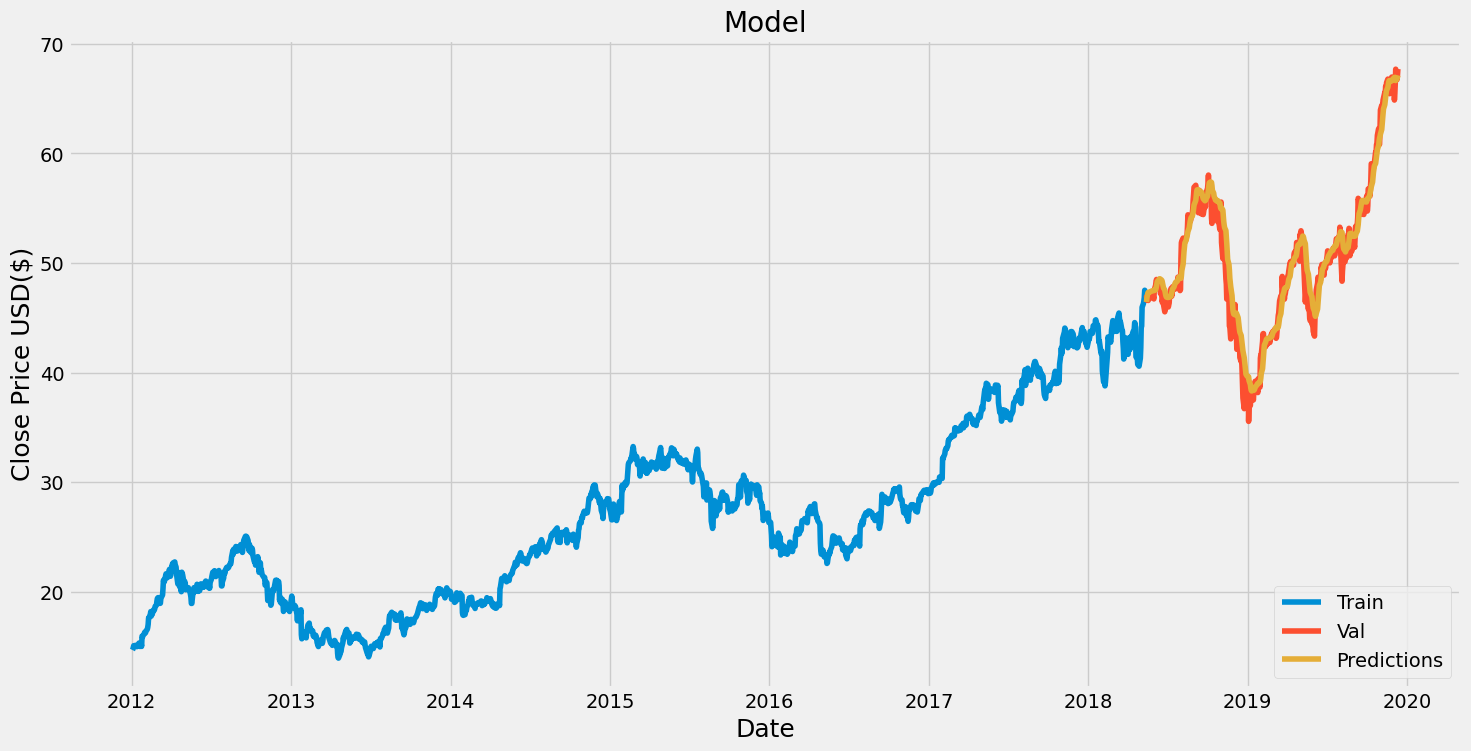

In [9]:
# Create the data for the graph
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions

#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()


In [10]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-14,47.037498,46.436657
2018-05-15,46.610001,46.821930
2018-05-16,47.044998,47.054153
2018-05-17,46.747501,47.228661
2018-05-18,46.577499,47.320450
...,...,...
2019-12-05,66.394997,66.665916
2019-12-06,67.677498,66.644096
2019-12-09,66.730003,66.816757


In [11]:
#Get the quote to predict the price
apple_quote=yf.download('AAPL', start = '2012-01-01', end='2019-12-17')
#create a new dataframe
new_df=apple_quote.filter(['Close'])
#get the last 60 day closing price values and convert the dataframe to an array
last_60_days=new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled=scaler.transform(last_60_days)
#create an empty list
X_test=[]
#append the past 60 days
X_test.append(last_60_days_scaled)

#convert the X_test data to a numpy array
X_test=np.array(X_test)

#reshape
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

#get the predicted scaled price
pred_price=model.predict(X_test)

#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(pred_price)



[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 38ms/step
[[68.35171]]


In [12]:
#Get the quote to check the actual price for that day
apple_quote2=yf.download('AAPL', start = '2019-12-17', end='2019-12-18')

# print(df['Close'])
print(apple_quote2['Close'])


[*********************100%%**********************]  1 of 1 completed
Date
2019-12-17    70.102501
Name: Close, dtype: float64
